#### LIBRERIAS

In [1]:
import pandas as pd

from datetime import datetime
from datetime import date

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re

import unicodedata
import math
from itertools import cycle
import xlsxwriter
import pyodbc
from datetime import timedelta
import matplotlib

import random
from IPython.display import display, HTML

import sys

import tkinter as tk
from tkinter import ttk
from tkinter import PhotoImage
from PIL import ImageTk, Image
import os

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


#### FUNCIONES

In [2]:
def calcula_dv(rut_base):
    # CONVERTIR EL RUT BASE A UNA CADENA Y REVERTIRLA
    reversed_digits = list(map(int, str(rut_base)[::-1]))
    # DEFINIR LOS FACTORES (2..7) QUE SE REPITEN EN CICLO
    factors = list(range(2, 8))
    # CALCULAR LA SUMA DE LOS PRODUCTO
    suma = sum(d * f for d, f in zip(reversed_digits, factors * (len(reversed_digits) // len(factors) + 1)))
    # CALCULA DV
    dv = (-suma) % 11
    return 'K' if dv == 10 else str(dv)

def remove_leading_zeros(rut):
    rut_part, dv = rut.split('-')
    rut_part = rut_part.lstrip('0')
    if not rut_part:
        rut_part = '0'
    return f"{rut_part}-{dv}"

def reemplazar_k(identificador):
    return identificador[:-1:] + identificador[-1].upper()

def separar_rut(numero):
    numero_str = str(numero)
    # TOMAR EL ULTIMO DIGITO
    parte_numerica = numero_str[:-1]
    digito_verificador = numero_str[-1]
    # FORMTATEAR GUION
    rut_formateado = f"{parte_numerica}-{digito_verificador}"
    return rut_formateado

In [3]:
### SEÑAL DE APORTES ELEVADOS EN UN DIA PARTICULAR
### FILTRAR TEMA DE LOS DOF O ALERTAS SEGÚN FILTRO ADICIONAL, DE LA CUSTODIA, PROMEDIO DE APORTES, APORTE MAX, ETC
## QRY ADICIONAL AL FILTRADO SOBRE CUSTODIA, ETC; TOMAR APORTE MAX, CUSTODIA EL DÍA DE LA SEÑAL, 

## INCORPORAR DENTRO DEL MANUAL RIESGOS DE LA PLATAFORMA (ESPECIALMENTE RACIONAL)
## AÑADIR CUSTODIA APORTE EN UN DÍA QUE SEA SUMAMENTE ELEVADO
# RELACIONAR MONTO TRANSADO O PROMEDIO DE APORTES PARA FILTRAR SI EL DOF ES NECESARIO DISPARARLO

## AÑADIR ALERTA ADICIONAL QUE HAYA APORTE ELEVADO, (NO SOLO EL PRIMER DIA) Y LEVANTAR LA SEÑAL
# PRUEBAS DE A CUANTO LES GENERARÍA EL DOF


## MUESTRA MÁS HETEROGENEA PARA VER A CUANTOS LES LLEGARIA EL DOF

#### MUESTRA CLIENTES: 

Se toma muestra clientes de Ficha PEP desde Regcheq para desde esta base tomar las operaciones y aportes y rescates.

In [4]:
df_muestra2 = pd.read_excel("M5 - Clientes custodia sobre 40M/Clientes_M5.xlsx")

In [5]:
identificadores = df_muestra2['IDENTIFICADOR'].tolist()
# SEPARAR POR COMAS
m = len(identificadores)
identificadores_str = ','.join([f"'{id}'" for id in identificadores])

#### CONSULTAS:
1. query_APORET: toma los aportes y los retiros
2. query_INFO: toma la info personal
3. query_CUSTODIA: operaciones del cliente

4. query_OPERACIONES ## criterio aportes e inmovilizado sin ningun tipo de operacion
5. query_SALDO_CAJA ## saldo caja primer mes y compararlo a finales, si en ambos esta sobre 10kk sospecha

In [6]:
m = df_muestra2['IDENTIFICADOR'].nunique()

In [7]:
F_i = '2023-06-01'
F = '2024-09-30' 

F_ic = '2024-09-30' 

## tomar menos tiempo custodia
F_ix = '2024-01-01'

#### TOMAR DATOS XLSX

In [8]:
#### TOMA DATOS DESDE EL EXCEL PARA LAS PRUEBAS
df_APORET_detalle = pd.read_excel('M5 - Clientes custodia sobre 40M/aportesM5.xlsx')  
df_APORET_detalle.shape
df_APORET_RESUMEN = df_APORET_detalle.groupby(['IDENTIFICADOR', 'NOMBRE_CLI','CARGO_ABONO', 'TIPO_CAJA'], as_index=False)['MONTO_CLP'].sum()

### DATOS CLIENTES
df_DATOS_clientes = pd.read_excel("M5 - Clientes custodia sobre 40M/datosM5.xlsx")  
## OPERACIONES
df_operaciones = pd.read_excel('M5 - Clientes custodia sobre 40M/operacionesM5.xlsx') 

## CUSTODIA
df_custodia_detalle = pd.read_excel("M5 - Clientes custodia sobre 40M/custodiaM5.xlsx") 
## CAJA
df_saldo_caja = pd.read_excel("M5 - Clientes custodia sobre 40M/cajaM5.xlsx") 

In [9]:
df_saldo_caja['IDENTIFICADOR'] = df_saldo_caja['IDENTIFICADOR'].apply(reemplazar_k)
df_custodia_detalle['IDENTIFICADOR'] = df_custodia_detalle['IDENTIFICADOR'].apply(reemplazar_k)
df_operaciones['IDENTIFICADOR'] = df_operaciones['IDENTIFICADOR'].apply(reemplazar_k)
df_DATOS_clientes['IDENTIFICADOR'] = df_DATOS_clientes['IDENTIFICADOR'].apply(reemplazar_k)
df_APORET_detalle['IDENTIFICADOR'] = df_APORET_detalle['IDENTIFICADOR'].apply(reemplazar_k)

In [10]:
df_dolar_obs = pd.read_excel("dol_observado.xlsx") 

df_operaciones = pd.merge(df_operaciones, df_dolar_obs[['FECHA_OPERACION', 'DOLAR_OBS']], on='FECHA_OPERACION', how='left')
df_operaciones['DOLAR_OBS'] = df_operaciones['DOLAR_OBS'].fillna(' ')

df_operaciones['MONTO_CLP'] = df_operaciones.apply(
    lambda row: row['MONTO'] * row['DOLAR_OBS'] if row['COD_MONEDA_OP'] == 'USD' else row['MONTO'], 
    axis=1
)

In [11]:
df_operaciones.sample(2)

,Unnamed: 0,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLIENTE,NOMBRE_ASESOR,FECHA_OPERACION,COD_TIPO_OPERACION,DSC_OPERACION_CONCEPTO,COD_MONEDA_OP,NEMOTECNICO,DSC_INSTRUMENTO,COD_SUB_CLASE_INSTRUMENTO,CANTIDAD,MONTO,MONTO_OPERACION,DOLAR_OBS,MONTO_CLP
18464,18464,8876875/60,8876875-2,Alex Garcia Lancaster,RACIONAL .,2023-06-05,COMPRA,COMPRA SPOT,CLP,USD,USD,SPOT_NAC,619.11,500000.0,500000.0,797.97,500000.0
3564,3564,16231468/80,16231468-8,Hernaldo Andrés González Mena,TRII .,2023-06-19,CIRV,COMPRA ACCIONES CB,CLP,PLANVITAL,A.F.P PLANVITAL S.A.,ACC,14000.00,1337000.0,3736513.0,793.35,1337000.0


#### PASAR DATOS A XLSX

In [12]:
#df_operaciones.to_excel("M5 - Clientes custodia sobre 40M/operacionesM5.xlsx")
#df_APORET_detalle.to_excel("M5 - Clientes custodia sobre 40M/aportesM5.xlsx")
#df_DATOS_clientes.to_excel("M5 - Clientes custodia sobre 40M/datosM5.xlsx")
#df_custodia_detalle.to_excel("M5 - Clientes custodia sobre 40M/custodiaM5xlsx")
#df_saldo_caja.to_excel("M5 - Clientes custodia sobre 40M/cajaM5.xlsx")


## CRITERIOS APORTES Y RESCATES

### CRITERIOS APORTES 

#### 1. APORTE SUPERA UMBRAL 

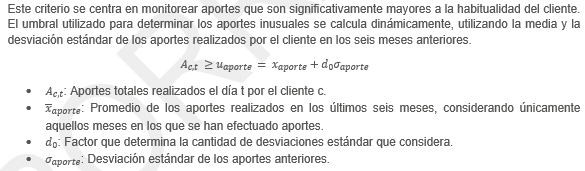

**PARÁMETROS DIFERENCIADOS:**
Según el tipo de persona son los parámetros $\alpha$ y $\beta$, que definen los aportes a monitorear 
al igual que si la persona pertenece a una lista de alto riesgo como:

&emsp;- Personas Expuestas Políticamente <br>
&emsp;- Causa Judicial por Delito Precedente <br>
&emsp;- Persona Jurídica o Natural residente en comuna con Zona Franca <br>
&emsp;- Listado de países y territorios no cooperantes según la OCDE y GAFI <br>
&emsp;- Personas Jurídicas con giro catalogado como riesgoso <br>

<table>
  <thead>
    <tr>
      <th>TIPO_PER</th>
      <th>RIESGO</th>
      <th>Alpha</th>
      <th>Beta</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>NATURAL</td>
      <td>ALTO</td>
      <td>500,000</td>
      <td>10,000,000</td>
    </tr>
    <tr>
      <td>NATURAL</td>
      <td></td>
      <td>2,000,000</td>
      <td>20,000,000</td>
    </tr>
    <tr>
      <td>JURIDICA</td>
      <td></td>
      <td>7,000,000</td>
      <td>70,000,000</td>
    </tr>
  </tbody>
</table>
as:


In [13]:
# ASIGNAR ALPHA Y BETA
def asignar_limites(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 500_000, 8_000_000  # Alpha_NR, Beta_NR
        else:
            return 1_000_000, 16_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        if row['RIESGO'] == 'ALTO':
            return 3_500_000, 35_000_000  # Alpha_NR, Beta_NR
        else:
            return 7_000_000, 70_000_000  # Alpha_N, Beta_N

**SUB DF DE APORTES A MONITOREAR:**
De todos los aportes disponibles se toma una porción de los aportes dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los aportes.

In [14]:
Aportes = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'A']
df_Aportes_copia = Aportes.copy()

# FORMATO FECHA
df_Aportes_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Aportes_copia['FECHA_MOVIMIENTO'])  
df_Aportes_copia['MES'] = df_Aportes_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Aportes_copia = df_Aportes_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA
df_Aportes_copia[['Alpha', 'Beta']] = df_Aportes_copia.apply(asignar_limites, axis=1, result_type='expand')
# FILTRAR APORTES MAYORES A ALPHA
df_Aportes_copia_filtrado = df_Aportes_copia[df_Aportes_copia['MONTO_CLP'] >= df_Aportes_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_A = df_Aportes_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_A = df_resumen_A.merge(df_Aportes_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_A = meses_superan_Beta_A[meses_superan_Beta_A['MONTO_CLP'] >= meses_superan_Beta_A['Beta']][['IDENTIFICADOR', 'MES']]
df_Aportes_copia_superan_Beta = df_Aportes_copia.merge(meses_superan_Beta_A, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO
df_combinado_A = pd.concat([df_Aportes_copia_filtrado, df_Aportes_copia_superan_Beta]).drop_duplicates()

monto_test = 50_000
df_combinado_A = df_combinado_A[df_combinado_A['MONTO_CLP'] >= monto_test]

# COLUMNA AUXILIAR MES_NUM
df_combinado_A['MES_NUM'] = df_combinado_A['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_combinado_A['MES_NUM'] = df_combinado_A['MES_NUM'] - df_combinado_A['MES_NUM'].min() + 1
#del df_combinado_A['Unnamed: 0']

<table>
  <thead>
    <tr>
      <th>Nm_A</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
  </tbody>
</table>y>
</table>

</table>
  

In [15]:
# PARAMETROS ESTADÍSTICA
Nm_A = 4

In [16]:
# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_A = df_combinado_A.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_A['MES_NUM2'] = (df_combinado_A.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))

# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_A.groupby('IDENTIFICADOR'):

    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_A)]
        promedio_aportes = ultimos_n_meses['MONTO_CLP'].mean()
        std_aportes = ultimos_n_meses['MONTO_CLP'].std()
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_aportes': promedio_aportes,
            'std_aportes': std_aportes
        })

# CREAR DF
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados[df_resultados['IDENTIFICADOR'] == identifier].index[:Nm_A]
    df_resultados.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'

df_grouped_A = df_resultados.copy()
df_grouped_A['promedio_aportes'] = pd.to_numeric(df_grouped_A['promedio_aportes'], errors='coerce')
df_grouped_A['std_aportes'] = pd.to_numeric(df_grouped_A['std_aportes'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\2427440520.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'


In [17]:
df_grouped_A[df_grouped_A['IDENTIFICADOR'] == '17404451-1'].sort_values(by='promedio_aportes')

,IDENTIFICADOR,MES,promedio_aportes,std_aportes
3468,17404451-1,2024-05,1.300228e+06,259737.089150
3475,17404451-1,2024-09,1.328579e+06,437077.559046
3467,17404451-1,2024-04,1.338228e+06,323151.579727
3466,17404451-1,2024-03,1.358228e+06,329830.456670
3465,17404451-1,2024-02,1.407500e+06,313195.891842
3473,17404451-1,2024-08,1.416546e+06,461188.018774
3469,17404451-1,2024-06,1.510228e+06,275201.408936
3471,17404451-1,2024-07,1.576219e+06,386143.513740
3462,17404451-1,2023-11,1.737051e+06,675879.997105
3463,17404451-1,2023-12,1.772051e+06,651223.069682


**APORTE SUPERA EL UMBRAL:** $d_0$ cantidad de desviaciones estándar dentro del umbral

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_A</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_0$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_a$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>2</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [18]:
# PARÁMETROS
n_meses = 4
d_0 = 3.5
th_a = 1.5
th_nstd = 2

In [19]:
alertas_aporte = []

for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]

    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)
    
    # ITERAR DESDE n_meses HASTA FINAL DF
    for i in range(n_meses, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        promedio_aportes = df_cliente.iloc[i]['promedio_aportes']
        std_aportes = df_cliente.iloc[i]['std_aportes']

        # APORTES MES ACTUAL
        aportes_actuales_filtro = df_combinado_A[
            (df_combinado_A['MES'] == mes_actual) &
            (df_combinado_A['IDENTIFICADOR'] == id_cliente)
        ]

        # ITERA SOBRE APORTES
        for _, aporte_fila in aportes_actuales_filtro.iterrows():
            aporte_actual = aporte_fila['MONTO_CLP']
            fecha_movimiento = aporte_fila['FECHA_MOVIMIENTO']

            # UMBRAL
            if std_aportes == 0:
                umbral = promedio_aportes * th_nstd # THRESHOLD SIN STD
            else:
                umbral = th_a *(promedio_aportes + d_0 * std_aportes)  # NORMAL
            
            # OBTIENE APORTES SOBRE UMBRAL
            if aporte_actual > umbral:
                alertas_aporte.append({
                    'MES': mes_actual,
                    'IDENTIFICADOR': id_cliente,
                    'aporte_actual': aporte_actual,
                    'fecha_aporte': fecha_movimiento,
                    'promedio_aportes': promedio_aportes,
                    'std_aportes': std_aportes,
                    'umbral': umbral
                })

df_alerta_APORTESUPERAUMBRAL = pd.DataFrame(alertas_aporte)

In [20]:
df_resultados[df_resultados['IDENTIFICADOR'] == '17407729-0']

,IDENTIFICADOR,MES,promedio_aportes,std_aportes
3541,17407729-0,2023-07,n/a,n/a
3542,17407729-0,2023-08,n/a,n/a
3543,17407729-0,2023-10,n/a,n/a
3545,17407729-0,2023-12,n/a,n/a
3546,17407729-0,2024-01,1160000.0,89442.7191
3547,17407729-0,2024-02,1160000.0,89442.7191
3549,17407729-0,2024-03,2433333.333333,1989639.833404
3551,17407729-0,2024-05,3200000.0,2000000.0
3552,17407729-0,2024-08,3283333.333333,1897805.750509
3553,17407729-0,2024-09,3583333.333333,1625320.481218


In [153]:
df_grouped_A[df_grouped_A['IDENTIFICADOR'] == '17407729-0']

,MES,IDENTIFICADOR,promedio_aportes,std_aportes,count_aportes,coef_var,alerta
94,2023-07,17407729-0,1200000.0,NaN,1,NaN,False
171,2023-08,17407729-0,1200000.0,NaN,1,NaN,False
324,2023-10,17407729-0,1200000.0,0.000000e+00,2,0.000000,False
520,2023-12,17407729-0,1000000.0,NaN,1,NaN,False
653,2024-01,17407729-0,1200000.0,NaN,1,NaN,False
781,2024-02,17407729-0,5000000.0,0.000000e+00,2,0.000000,False
921,2024-03,17407729-0,3500000.0,2.121320e+06,2,0.606092,False
1208,2024-05,17407729-0,1500000.0,NaN,1,NaN,False
1639,2024-08,17407729-0,3000000.0,NaN,1,NaN,False
1769,2024-09,17407729-0,1100000.0,NaN,1,NaN,False


In [21]:
df_alerta_APORTESUPERAUMBRAL = pd.merge(df_alerta_APORTESUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [22]:
df_alerta_APORTESUPERAUMBRAL[df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'] == '17407729-0']

,MES,IDENTIFICADOR,aporte_actual,fecha_aporte,promedio_aportes,std_aportes,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
23,2024-02,17407729-0,5000000.0,2024-02-12,1160000.0,89442.7191,2.209574e+06,TERESITA ALESSANDRI CRUZAT,NATURAL,
24,2024-02,17407729-0,5000000.0,2024-02-12,1160000.0,89442.7191,2.209574e+06,TERESITA ALESSANDRI CRUZAT,NATURAL,


In [23]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESUPERAUMBRAL.shape[0]}\n",
      df_alerta_APORTESUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 23 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 6.42 % 
Cantidad de veces que se levanta la señal: 31
 MES
2023-11    2
2024-01    1
2024-02    4
2024-03    7
2024-04    1
2024-05    1
2024-06    3
2024-07    3
2024-09    9
Freq: M, Name: count, dtype: int64


In [24]:
df_alerta_APORTESUPERAUMBRAL_color = df_alerta_APORTESUPERAUMBRAL.copy()
############### COLOR ##################
unique_ids = df_alerta_APORTESUPERAUMBRAL_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_aporte_vs_umbral(row):
    aporte_vs_umbral = row['aporte_actual'] / row['umbral']
    if aporte_vs_umbral > 2:
        return ['background-color: red'] * len(row)  # Rojo claro
    elif aporte_vs_umbral > 1.7:
        return ['background-color: orange'] * len(row)  # Amarillo claro
    else:
        return [''] * len(row)


df_alerta_APORTESUPERAUMBRAL_color = (
    df_alerta_APORTESUPERAUMBRAL_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_aporte_vs_umbral, axis=1, subset=['aporte_actual', 'umbral'])
)

df_alerta_APORTESUPERAUMBRAL_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\464082306.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\464082306.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,aporte_actual,fecha_aporte,promedio_aportes,std_aportes,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-09,10577379-K,5000000.000000,2024-09-16 00:00:00,1400000.000000,400000.000000,4200000.000000,Cesar Esteban Bruna Diaz,NATURAL,
1,2024-02,11277742-3,10000000.000000,2024-02-16 00:00:00,3000000.000000,0.000000,6000000.000000,FERNANDO RODOLFO URRA HERRERA,NATURAL,
2,2024-02,11277742-3,20000000.000000,2024-02-16 00:00:00,3000000.000000,0.000000,6000000.000000,FERNANDO RODOLFO URRA HERRERA,NATURAL,
3,2024-07,13256647-K,13402269.573000,2024-07-23 00:00:00,2342857.142857,1604012.825029,11935353.045687,VERONICA REESE VIVANCO,NATURAL,
4,2024-09,13668051-K,4500000.000000,2024-09-10 00:00:00,1285714.285714,487950.036474,4490309.120061,BRAULIO HERNAN MENDOZA LEON,NATURAL,
5,2024-09,13952791-7,50000000.000000,2024-09-12 00:00:00,4542857.142857,919886.121316,11643687.851197,IGNACIO ANTONIO VÉJAR MAYORA,NATURAL,
6,2024-05,14010714-K,18603400.000000,2024-05-07 00:00:00,3342578.746508,1727301.457953,14082200.774013,FELIPE HARTWIG LANGEVIN,NATURAL,
7,2024-03,15317930-1,7000000.000000,2024-03-18 00:00:00,1386528.250000,534218.378393,4884438.861564,JUAN CARLOS TRONCOSO PINO,NATURAL,
8,2024-03,15317930-1,5500000.000000,2024-03-19 00:00:00,1386528.250000,534218.378393,4884438.861564,JUAN CARLOS TRONCOSO PINO,NATURAL,
9,2023-11,15383710-4,167000000.000000,2023-11-14 00:00:00,2732142.857143,2112381.734774,15188218.393278,PABLO RAMÍREZ CALVO,NATURAL,


#### 2. APORTE SE ALEJA DEL SEGMENTO DE APORTES SIMILARES DE OTROS CLIENTES:

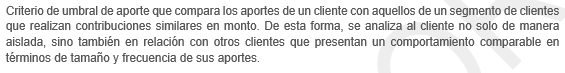

#### 3. CRITERIO APORTES SIMILARES EN MONTOS

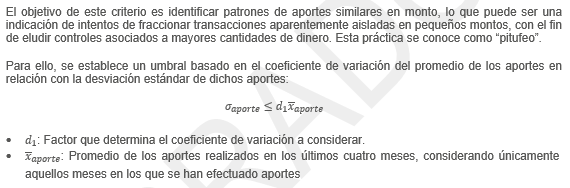

In [25]:
## COEFICIENTE DE VARIACION
df_grouped_A = df_combinado_A.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_aportes=('MONTO_CLP', 'mean'),
    std_aportes=('MONTO_CLP', 'std'),
    count_aportes=('MONTO_CLP', 'size')
).reset_index()

d_1 = 0.1
cant_minima_aportes = 5
df_grouped_A['coef_var'] = df_grouped_A['std_aportes'] / df_grouped_A['promedio_aportes']
df_grouped_A['alerta'] = (df_grouped_A['coef_var'] <= d_1) & (df_grouped_A['count_aportes'] >= cant_minima_aportes)

# FILTRA LOS DE LA ALERTA
df_alerta_APORTESIMILARES = df_grouped_A[df_grouped_A['alerta']]
df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES.reset_index(drop=True)

In [26]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESIMILARES.shape[0]}\n",
      df_alerta_APORTESIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 41 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 11.45 % 
Cantidad de veces que se levanta la señal: 51
 MES
2023-07    1
2023-08    2
2023-10    4
2023-11    4
2023-12    3
2024-01    5
2024-02    1
2024-03    5
2024-04    6
2024-05    4
2024-06    6
2024-07    5
2024-08    4
2024-09    1
Freq: M, Name: count, dtype: int64


In [27]:
df_alerta_APORTESIMILARES = pd.merge(df_alerta_APORTESIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [28]:
############### COLOR ##################
df_alerta_APORTESIMILARES_color = df_alerta_APORTESIMILARES.copy()
unique_ids = df_alerta_APORTESIMILARES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_APORTESIMILARES_color = (
    df_alerta_APORTESIMILARES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

#df_alerta_APORTESIMILARES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\3706790349.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\3706790349.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 4.	APORTES MAYORES AL PATRIMONIO VALORIZADO DEL CLIENTE

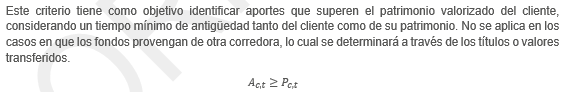

In [29]:
# ASIGNAR ALPHA Y BETA
def asignar_limites_aporte_mayor_custodia(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'PEP':
            return 3_000_000
        else:
            return 7_000_000
    elif row['TIPO_PER'] == 'JURIDICA':
        return 50_000_000

In [30]:
df_custodia_detalle = df_custodia_detalle.copy()

df_custodia_consolidado = df_custodia_detalle.groupby(['IDENTIFICADOR', 'fecha_cierre'], as_index=False).sum('VALOR_MERCADO_CLP')
df_custodia_consolidado = df_custodia_consolidado[['IDENTIFICADOR','fecha_cierre','VALOR_MERCADO_CLP']]

In [31]:
df_custodia_consolidado_copia = df_custodia_consolidado.copy().merge(
    df_muestra2[['IDENTIFICADOR', 'RIESGO','TIPO_PER']], 
    on='IDENTIFICADOR', 
    how='left'  # Use 'left' join to keep all rows from df_custodia_consolidado
).fillna(' ')


In [32]:
# CREA COLUMNAS index
df_custodia_consolidado_copia['index_custodia'] = df_custodia_consolidado_copia.apply(asignar_limites_aporte_mayor_custodia, axis=1, result_type='expand')

In [33]:
# MERGE df_custodia_consolidado y df_APORET_detalle_2 por IDENTIFICADOR y fechas
df_merged = pd.merge(df_custodia_consolidado_copia, 
                     df_combinado_A, 
                     left_on=['IDENTIFICADOR', 'fecha_cierre'], 
                     right_on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                     how='inner')

### APORTE (MONTO_CLP) mayor a custodia (VALOR_MERCADO_CLP)
cond1 = df_merged['MONTO_CLP'] > df_merged['VALOR_MERCADO_CLP']
cond2 = df_merged['VALOR_MERCADO_CLP'] > df_merged['index_custodia']

df_aporte_mayor_custodia = (df_merged[cond1 & cond2])

In [34]:
col_show = ['IDENTIFICADOR','fecha_cierre','VALOR_MERCADO_CLP','NUM_CUENTA','NOMBRE_CLI','MONTO_CLP','TIPO_PER_x','RIESGO_x']

df_aporte_mayor_custodia = df_aporte_mayor_custodia[col_show].reset_index(drop=True)

In [35]:
df_aporte_mayor_custodia.sample(2)

,IDENTIFICADOR,fecha_cierre,VALOR_MERCADO_CLP,NUM_CUENTA,NOMBRE_CLI,MONTO_CLP,TIPO_PER_x,RIESGO_x
24,5549423-1,2024-03-15,94897336,5549423/60,LEONEL FERNANDO SEARLE COUVE,95000000.0,NATURAL,
20,19078440-1,2024-04-10,75959888,19078440/50,LUCÍA MIR CERDA,110000000.0,NATURAL,


In [36]:
df_APORET_detalle[(df_APORET_detalle['IDENTIFICADOR'] == '15152034-0') & (df_APORET_detalle['FECHA_MOVIMIENTO'] == '2024-05-10')]

,Unnamed: 0,CARGO_ABONO,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLI,COD_MOV,DSC_MOV_CAJA,FECHA_MOVIMIENTO,FECHA_LIQUIDACION,MONTO,NOMBRE_ASESOR,TIPO_CAJA,COD_MONEDA,OBS_MOV_CAJA,T_C,MONTO_CLP
1684,1684,A,15152034/50,15152034-0,PAULA MARCELA VILLALOBOS MOLINA,APO_PAT,APORTE PATRIMONIAL,2024-05-10,2024-05-10,148000000.0,BETTERPLAN ADVISORS SPA .,CAJA PESO,CLP,[WS],1.0,148000000.0
1685,1685,A,15152034/50,15152034-0,PAULA MARCELA VILLALOBOS MOLINA,APO_PAT,APORTE PATRIMONIAL,2024-05-10,2024-05-10,148000000.0,BETTERPLAN ADVISORS SPA .,CAJA PESO,CLP,[WS],1.0,148000000.0


In [37]:
df_aporte_mayor_custodia.rename(columns={
    'TIPO_PER_x': 'TIPO_PER', 
    'RIESGO_x': 'RIESGO'
}, inplace=True)
df_aporte_mayor_custodia

,IDENTIFICADOR,fecha_cierre,VALOR_MERCADO_CLP,NUM_CUENTA,NOMBRE_CLI,MONTO_CLP,TIPO_PER,RIESGO
0,11833342-K,2024-08-05,47129306,11833342/50,MARIANA ORREGO SANCHEZ,4.755550e+07,NATURAL,
1,11862862-4,2024-02-27,178279920,11862862/50,MARIA DE LOS ANGELES DONOSO ORELLANA,1.800000e+08,NATURAL,
2,12175480-0,2024-09-25,49741050,12175480/50,PEDRO FELIPE FIGUEROA OPAZO,5.000000e+07,NATURAL,
3,12662240-6,2024-03-14,33162880,12662240/50,CLAUDIA SERVERA CAMPUSANO,3.350000e+07,NATURAL,
4,14010714-K,2024-05-07,8099191,14010714/60,FELIPE HARTWIG LANGEVIN,1.860340e+07,NATURAL,
5,14021499-K,2024-05-13,27460959,14021499/50,JUAN CARLOS MUÑOZ REBOLLEDO,4.000000e+07,NATURAL,
6,14376204-1,2024-07-05,61057506,14376204/50,PABLO ANTONIO DÍAZ FUENZALIDA,6.500000e+07,NATURAL,
7,15152034-0,2024-05-10,15950631,15152034/50,PAULA MARCELA VILLALOBOS MOLINA,1.480000e+08,NATURAL,
8,15152034-0,2024-05-10,15950631,15152034/50,PAULA MARCELA VILLALOBOS MOLINA,1.480000e+08,NATURAL,
9,15725884-2,2024-01-22,12682639,15725884/60,CHRISTOPHER MORAGA INOSTROZA,4.017252e+07,NATURAL,


In [38]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M') 

In [39]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_aporte_mayor_custodia['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_aporte_mayor_custodia['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_aporte_mayor_custodia.shape[0]}\n",
      df_aporte_mayor_custodia.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 27 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 7.54 % 
Cantidad de veces que se levanta la señal: 28
 MES
2024-01    5
2024-02    2
2024-03    2
2024-04    4
2024-05    5
2024-06    1
2024-07    5
2024-08    2
2024-09    2
Freq: M, Name: count, dtype: int64


In [40]:
df_aporte_mayor_custodia_color = df_aporte_mayor_custodia.copy()

unique_ids = df_aporte_mayor_custodia_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_aporte_vs_custodia(row):
    aporte_vs_custodia = row['MONTO_CLP'] / row['VALOR_MERCADO_CLP']
    if aporte_vs_custodia > 1.5:
        return ['background-color: red'] * len(row)  # Rojo claro
    elif aporte_vs_custodia > 1.2:
        return ['background-color: orange'] * len(row)  # Rojo claro
    else:
        return [''] * len(row)


df_aporte_mayor_custodia_color = (
    df_aporte_mayor_custodia_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_aporte_vs_custodia, axis=1, subset=['VALOR_MERCADO_CLP', 'MONTO_CLP'])
)

#df_aporte_mayor_custodia_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1135623371.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1135623371.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 5. CRITERIO PRIMER APORTE CONSIDERABLEMENTE ALTO

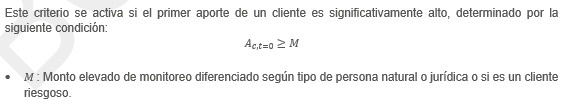

<table>
  <thead>
    <tr>
      <th>TIPO_PER</th>
      <th>RIESGO</th>
      <th>M</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>NATURAL</td>
      <td>ALTO</td>
      <td>10 000 000</td>
    </tr>
    <tr>
      <td>NATURAL</td>
      <td></td>
      <td>40 000 000</td>
    </tr>
    <tr>
      <td>JURIDICA</td>
      <td></td>
      <td>300 000 000</td>
    </tr>
  </tbody>
</table>
000r>
  </tbody>
</table>


In [41]:
# M SEGÚN SEGMENTO
def asignar_M(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'PEP':
            return 10_000_000 # Alpha_NR, Beta_NR
        else:
            return 20_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        return 300_000_000  # Alpha_J, Beta_J

In [42]:
df_combinado_A['M'] = df_combinado_A.apply(asignar_M, axis=1)
df_combinado_A_sorted = df_combinado_A.sort_values(by='FECHA_MOVIMIENTO')
Primer_Dia_Aporte_Cliente = df_combinado_A_sorted.groupby('IDENTIFICADOR')['FECHA_MOVIMIENTO'].first().reset_index()

# UNIR CON EL DATAFRAME ORIGINAL PARA OBTENER LOS MOVIMIENTOS CORRESPONDIENTES AL primer dia
Movimientos_Primer_Dia = df_combinado_A_sorted.merge(Primer_Dia_Aporte_Cliente, 
                                                     on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                                                     how='inner')

# SUMAR MONTOS PRIMER DIA
Suma_Primer_Aporte_Cliente = Movimientos_Primer_Dia.groupby('IDENTIFICADOR').agg(
    {'MONTO_CLP': 'sum', 'NOMBRE_CLI': 'first', 'FECHA_MOVIMIENTO': 'first', 'M': 'first'}).reset_index()

# FILTRAR
Señal_Primer_Aporte_Grande = Suma_Primer_Aporte_Cliente[Suma_Primer_Aporte_Cliente['MONTO_CLP'] >= Suma_Primer_Aporte_Cliente['M']]
Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande[['IDENTIFICADOR', 'NOMBRE_CLI', 'FECHA_MOVIMIENTO', 'MONTO_CLP']].sort_values(by='IDENTIFICADOR')

In [43]:
Señal_Primer_Aporte_Grande_Alerta = pd.merge(Señal_Primer_Aporte_Grande_Alerta, df_muestra2[['IDENTIFICADOR','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [44]:
Señal_Primer_Aporte_Grande_Alerta['MES'] = Señal_Primer_Aporte_Grande_Alerta['FECHA_MOVIMIENTO'].dt.to_period('M') 

In [45]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Primer_Aporte_Grande_Alerta.shape[0]}\n",
      Señal_Primer_Aporte_Grande_Alerta.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 37 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 10.34 % 
Cantidad de veces que se levanta la señal: 37
 MES
2023-06    5
2023-07    2
2023-08    2
2024-01    4
2024-02    2
2024-03    1
2024-04    3
2024-05    4
2024-06    2
2024-07    5
2024-08    3
2024-09    4
Freq: M, Name: count, dtype: int64


In [46]:
Señal_Primer_Aporte_Grande_Alerta_color = Señal_Primer_Aporte_Grande_Alerta.copy()
############### COLOR ##################
unique_ids = Señal_Primer_Aporte_Grande_Alerta_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)

color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
Señal_Primer_Aporte_Grande_Alerta_color = (
    Señal_Primer_Aporte_Grande_Alerta_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

#Señal_Primer_Aporte_Grande_Alerta_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\523656640.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\523656640.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 5.5. APORTES DURANTE DÍA ELEVADO

In [47]:
# AGRUPAR OPERACIONES POR DIA Y MONTO PARA FILTRAR EL MONTO MINIMO DE OPERACION
df_diario_A = df_combinado_A.groupby(['IDENTIFICADOR', 'FECHA_MOVIMIENTO']).agg(
    total_monto_diario=('MONTO_CLP', 'sum')
).reset_index()

df_diario_A['MES'] = df_diario_A['FECHA_MOVIMIENTO'].dt.to_period('M') 

# AGRUPAR MENSUALMENTE
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum')
).reset_index()

# M SEGÚN SEGMENTO
def asignar_adiario(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 40_000_000 if row['RIESGO'] == 'PEP' else 100_000_000
    return 250_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

def asignar_amensual(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 100_000_000 if row['RIESGO'] == 'PEP' else 200_000_000
    return 500_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

df_diario_A = df_diario_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER','RIESGO','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario_A['M_diario'] = df_diario_A.apply(asignar_adiario, axis=1)

Señal_Aporte_Diario_Grande = df_diario_A[df_diario_A['total_monto_diario'] >= df_diario_A['M_diario']]

In [48]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Diario_Grande.shape[0]}\n",
      Señal_Aporte_Diario_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 22 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 6.15 % 
Cantidad de veces que se levanta la señal: 25
 MES
2023-06    2
2023-07    1
2023-11    1
2023-12    1
2024-01    1
2024-02    1
2024-03    1
2024-04    1
2024-05    2
2024-06    5
2024-07    5
2024-08    3
2024-09    1
Freq: M, Name: count, dtype: int64


In [49]:
df_diario_A.sample(2)

,IDENTIFICADOR,FECHA_MOVIMIENTO,total_monto_diario,MES,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_diario
3795,23752068-8,2024-02-16,5000000.0,2024-02,NATURAL,,CARLOS PRIETO COCA,100000000
2026,16607752-4,2024-01-31,3000000.0,2024-01,NATURAL,,STANISLAS ALBERT MIZGIER ROJAS,100000000


In [50]:
df_diario_A.sample(2)

,IDENTIFICADOR,FECHA_MOVIMIENTO,total_monto_diario,MES,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_diario
1431,15787508-6,2024-04-02,1000000.0,2024-04,NATURAL,,MARCO ANTONIO ESCOBAR PIÑONES,100000000
2777,17600360-K,2023-07-05,2000000.0,2023-07,NATURAL,,MACARENA GONZÁLEZ LIRA,100000000


In [51]:
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum'),
    dias_aportes=('FECHA_MOVIMIENTO', 'nunique')  # Cuenta días únicos de aportes
).reset_index()



df_mensual_A = df_mensual_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER','RIESGO','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_mensual_A['M_mensual'] = df_mensual_A.apply(asignar_amensual, axis=1)
Señal_Aporte_Mensual_Grande = df_mensual_A[(df_mensual_A['total_monto_mensual'] >= df_mensual_A['M_mensual']) & (df_mensual_A['dias_aportes'] >= 2)]

In [52]:
Señal_Aporte_Mensual_Grande

,IDENTIFICADOR,MES,total_monto_mensual,dias_aportes,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_mensual
172,13068960-4,2024-05,205000000.0,3,NATURAL,,WALDO BOWN INTVEEN,200000000
657,16369528-6,2024-03,230000000.0,2,NATURAL,,TOMAS VALDES DAVALOS,200000000
931,17088906-1,2024-06,200086000.0,2,NATURAL,,MARÍA ANTONIA ZALDÍVAR LARRAÍN,200000000


In [53]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Mensual_Grande.shape[0]}\n",
      Señal_Aporte_Mensual_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 3 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.84 % 
Cantidad de veces que se levanta la señal: 3
 MES
2024-03    1
2024-05    1
2024-06    1
Freq: M, Name: count, dtype: int64


#### 6. INCREMENTO EN LA FRECUENCIA DE APORTES

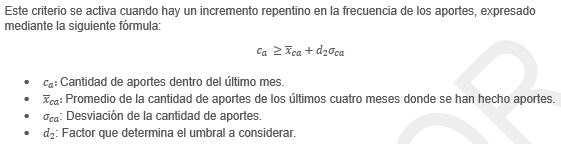

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>d_2</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_aportes</td>
      <td>5</td>
      <td>Cantidad mínima del aportes para el criterio</td>
    </tr>
    <tr>
      <td>TH</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [54]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_2 = 3
cant_min_aportes = 5
TH = 1.3

In [55]:
alertas_frecuencia_A = []
# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL n_meses, YA QUE SE REQUIEREN LOS n_meses ANTERIORES
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses DONDE HUBO APORTES
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR APORTES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_aportes'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASA AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # PROMEDIO Y DESVIACIÓN ESTÁNDAR DE APORTES
        promedio_aportes = ultimos_n_meses_validos['count_aportes'].mean()
        std_aportes = ultimos_n_meses_validos['count_aportes'].std()
        
        # CANTIDAD DE APORTES EN EL MES ACTUAL
        aportes_actual = df_cliente.iloc[i]['count_aportes']
        
        # CONDICIÓN DE UMBRAL FRECUENCIA DE APORTES: c_a ≥ x_ca + d_2 * σ_ca
        if aportes_actual > cant_min_aportes and aportes_actual > TH * (promedio_aportes + d_2 * std_aportes):
            alertas_frecuencia_A.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'aportes_actual': aportes_actual,
                'promedio_aportes': promedio_aportes,
                'std_aportes': std_aportes,
                'umbral': TH * (promedio_aportes + d_2 * std_aportes)
            })

# Crear DataFrame con las alertas
df_alerta_FRECUENCIAAPORTES = pd.DataFrame(alertas_frecuencia_A)

In [56]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIAAPORTES.shape[0]}\n",
      df_alerta_FRECUENCIAAPORTES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 18 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 5.03 % 
Cantidad de veces que se levanta la señal: 19
 MES
2023-11    1
2024-01    2
2024-02    1
2024-03    3
2024-05    2
2024-06    1
2024-07    2
2024-08    3
2024-09    4
Freq: M, Name: count, dtype: int64


In [57]:
df_alerta_FRECUENCIAAPORTES = pd.merge(df_alerta_FRECUENCIAAPORTES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [58]:
df_alerta_FRECUENCIAAPORTES_color = df_alerta_FRECUENCIAAPORTES.copy()
############### COLOR ##################
unique_ids = df_alerta_FRECUENCIAAPORTES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_FRECUENCIAAPORTES_color = (
    df_alerta_FRECUENCIAAPORTES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_FRECUENCIAAPORTES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1274986481.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1274986481.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,aportes_actual,promedio_aportes,std_aportes,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-02,11277742-3,6,1.500000,0.577350,4.201666,FERNANDO RODOLFO URRA HERRERA,NATURAL,
1,2024-03,15669770-2,18,2.000000,0.816497,5.784337,Eduardo Andres Hayden Offermann,NATURAL,
2,2024-06,15837447-1,21,4.750000,1.707825,12.835518,NICOLÁS EDUARDO VALDÉS RIQUELME,NATURAL,
3,2024-01,16017822-1,11,4.000000,0.000000,5.200000,JOSÉ GASPAR DE LA CARRERA GARRIDO,NATURAL,
4,2024-08,16231468-8,8,1.000000,0.000000,1.300000,HERNALDO ANDRÉS GONZÁLEZ MENA,NATURAL,
5,2024-09,16819976-7,7,1.500000,1.000000,5.850000,FERNANDO ESTAY PEREZ,NATURAL,
6,2024-09,17404451-1,10,1.750000,0.500000,4.225000,JUAN ROGERS ALCALDE,NATURAL,
7,2023-11,8833462-0,13,1.250000,0.500000,3.575000,Juan Carlos Zuñiga Diaz,NATURAL,
8,2024-05,17669780-6,10,1.750000,0.957427,6.008966,MARIO PORTILLA ESPINOZA,NATURAL,
9,2024-03,19246134-0,7,1.500000,0.577350,4.201666,CRISTÓBAL GAZALI ALLEN,NATURAL,


#### 7. CLIENTE APORTA Y TIENE EL DINERO INMOVILIZADO

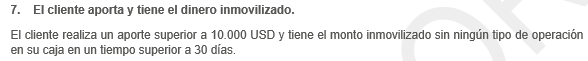

In [59]:
monto_inmovilizado = 10_000_000

In [60]:
df_saldo_caja['FECHA_CIERRE'] = pd.to_datetime(df_saldo_caja['FECHA_CIERRE'])
df_saldo_caja = df_saldo_caja[df_saldo_caja['MONTO_EN_PESOS'] > monto_inmovilizado]
df_saldo_caja = df_saldo_caja.sort_values(['IDENTIFICADOR', 'TIPO_CAJA', 'FECHA_CIERRE'])

def find_same_monto_consecutive_months(group):
    group['year_month_diff'] = (
        (group['FECHA_CIERRE'].dt.year - group['FECHA_CIERRE'].dt.year.shift(1)) * 12 +
        (group['FECHA_CIERRE'].dt.month - group['FECHA_CIERRE'].dt.month.shift(1))
    )
    
    group['same_monto_consecutive'] = (group['year_month_diff'] == 1) & (group['MONTO_MON_CAJA'] == group['MONTO_MON_CAJA'].shift(1))
    

    return group[group['same_monto_consecutive']]

result_df = df_saldo_caja.groupby(['IDENTIFICADOR', 'TIPO_CAJA']).apply(find_same_monto_consecutive_months).reset_index(drop=True)

#### restante ###
del result_df['Unnamed: 0']
### en criterio falta verificar que no tenga operaciones de la misma moneda de la caja inmovilizada durante el periodo con el mismo asesor asociado a la caja inmovilizada 

In [61]:
df_monto_inmovilizado = result_df.copy()
del df_monto_inmovilizado['ESTADO']
del df_monto_inmovilizado['year_month_diff']
del df_monto_inmovilizado['same_monto_consecutive']


In [62]:
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M') 

In [63]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_monto_inmovilizado['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_monto_inmovilizado['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_monto_inmovilizado.shape[0]}\n",
      df_monto_inmovilizado.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 2 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.56 % 
Cantidad de veces que se levanta la señal: 2
 MES
2024-02    1
2024-10    1
Freq: M, Name: count, dtype: int64


In [64]:
df_monto_inmovilizado

,NOMBRE_ASESOR,IDENTIFICADOR,NUM_CUENTA,NOMBRE_CLI,FECHA_CIERRE,TIPO_CAJA,MONTO_MON_CAJA,MONTO_EN_PESOS,TRANSITO,MES
0,BETTERPLAN ADVISORS SPA .,16369528-6,16369528/50,TOMAS VALDES DAVALOS,2024-10-01,CAJA DOLAR,2.171114e+04,19489653,0,2024-10
1,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-02-01,CAJA PESO,4.400000e+07,44000000,0,2024-02


In [65]:
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M') 

In [66]:
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M') 

In [67]:
df_saldo_caja[(df_saldo_caja['IDENTIFICADOR'] == '26205406-3') & (df_saldo_caja['NOMBRE_ASESOR'] == 'RACIONAL .') ]

,Unnamed: 0,NOMBRE_ASESOR,IDENTIFICADOR,NUM_CUENTA,NOMBRE_CLI,FECHA_CIERRE,ESTADO,TIPO_CAJA,MONTO_MON_CAJA,MONTO_EN_PESOS,TRANSITO
3899,3899,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-01-01,VIG,CAJA PESO,44000000.0,44000000,0
3168,3168,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-02-01,VIG,CAJA PESO,44000000.0,44000000,0
3956,3956,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-03-01,VIG,CAJA PESO,49000000.0,49000000,-5022000
3551,3551,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-09-01,VIG,CAJA PESO,34085035.0,34085035,0


In [68]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {result_df['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * result_df['IDENTIFICADOR'].nunique() / m, 2)} %")

La cantidad de clientes son: 358  
Clientes con señal de alerta: 2 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.56 %


In [69]:
df_operaciones_2 = df_operaciones.copy()
df_operaciones_2['MES'] = df_operaciones_2['FECHA_OPERACION'].dt.to_period('M') 

In [70]:
c1 = (df_operaciones_2['IDENTIFICADOR'] == '26205406-3')
c2 = (df_operaciones_2['NOMBRE_ASESOR'] == 'RACIONAL .')
c3 = (df_operaciones_2['MES'] == '2024-03') | (df_operaciones_2['MES'] == '2024-02') | (df_operaciones_2['MES'] == '2024-01') | (df_operaciones_2['MES'] == '2023-12')
df_operaciones_2[c1 & c2 & c3]

,Unnamed: 0,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLIENTE,NOMBRE_ASESOR,FECHA_OPERACION,COD_TIPO_OPERACION,DSC_OPERACION_CONCEPTO,COD_MONEDA_OP,NEMOTECNICO,DSC_INSTRUMENTO,COD_SUB_CLASE_INSTRUMENTO,CANTIDAD,MONTO,MONTO_OPERACION,DOLAR_OBS,MONTO_CLP,MES
8049,8049,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-03-12,CIRV,COMPRA ACCIONES CB,CLP,CAP,CAP S.A.,ACC,1842.0,12101549.0,12101549.0,966.29,12101549.0,2024-03
9547,9547,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-03-11,CIRV,COMPRA ACCIONES CB,CLP,CAP,CAP S.A.,ACC,5793.0,37459779.0,37459779.0,964.95,37459779.0,2024-03
10658,10658,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-03-12,VIFM,VENTA FONDOS CB,CLP,CFIETFCD,FI ETF SINGULAR CHILE CORTA DURACION,CFI,9878.0,11938594.0,11938594.0,966.29,11938594.0,2024-03
19582,19582,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-03-11,VIRV,VENTA ACCIONES CB,CLP,CAP,CAP S.A.,ACC,744.0,4807169.0,4807169.0,964.95,4807169.0,2024-03
20786,20786,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-02-29,CIRV,COMPRA ACCIONES CB,CLP,CAP,CAP S.A.,ACC,744.0,5022000.0,5022000.0,980.19,5022000.0,2024-02
25288,25288,26205406/60,26205406-3,RODNEY HERNÁNDEZ -,RACIONAL .,2024-03-11,CIFM,COMPRA FONDOS CB,CLP,CFIETFCD,FI ETF SINGULAR CHILE CORTA DURACION,CFI,9878.0,11937927.0,11937927.0,964.95,11937927.0,2024-03


### CRITERIO RETIROS

**SUB DF DE RESCATES A MONITOREAR:**
De todos los rescates disponibles se toma una porción de los rescates dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los rescates.

In [71]:
Rescates = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'C']
df_Rescates_copia = Rescates.copy()

# FORMATO FECHA
df_Rescates_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Rescates_copia['FECHA_MOVIMIENTO'])  
df_Rescates_copia['MES'] = df_Rescates_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Rescates_copia = df_Rescates_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA
df_Rescates_copia[['Alpha', 'Beta']] = df_Rescates_copia.apply(asignar_limites, axis=1, result_type='expand')
# FILTRAR APORTES MAYORES A ALPHA
df_Rescates_copia_filtrado = df_Rescates_copia[df_Rescates_copia['MONTO_CLP'] >= df_Rescates_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_R = df_Rescates_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_R = df_resumen_R.merge(df_Rescates_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_R = meses_superan_Beta_R[meses_superan_Beta_R['MONTO_CLP'] >= meses_superan_Beta_R['Beta']][['IDENTIFICADOR', 'MES']]
df_Rescates_copia_superan_Beta = df_Rescates_copia.merge(meses_superan_Beta_R, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO
df_combinado_R = pd.concat([df_Rescates_copia_filtrado, df_Rescates_copia_superan_Beta]).drop_duplicates()

# COLUMNA AUXILIAR MES_NUM
df_combinado_R['MES_NUM'] = df_combinado_R['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_combinado_R['MES_NUM'] = df_combinado_R['MES_NUM'] - df_combinado_R['MES_NUM'].min() + 1
#del df_combinado_R['Unnamed: 0']

<table>
  <thead>
    <tr>
      <th>Nm_R</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de rescates</td>
    </tr>
  </tbody>
</table>


In [72]:
# PARAMETROS ESTADÍSTICA
Nm_R = 4

# modificar

In [73]:
# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_R = df_combinado_R.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_R['MES_NUM2'] = (df_combinado_R.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))

# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_R.groupby('IDENTIFICADOR'):
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_R)]
        
        promedio_rescates = ultimos_n_meses['MONTO_CLP'].mean()
        std_rescates = ultimos_n_meses['MONTO_CLP'].std()
        
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_rescates': promedio_rescates,
            'std_rescates': std_rescates
        })

# CREAR DF
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados[df_resultados['IDENTIFICADOR'] == identifier].index[:Nm_R]
    df_resultados.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'

df_grouped_R = df_resultados.copy()
df_grouped_R['promedio_rescates'] = pd.to_numeric(df_grouped_R['promedio_rescates'], errors='coerce')
df_grouped_R['std_rescates'] = pd.to_numeric(df_grouped_R['std_rescates'], errors='coerce')


C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\4258978506.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'


#### 1. CRITERIO RETIROS SIMILARES EN MONTOS

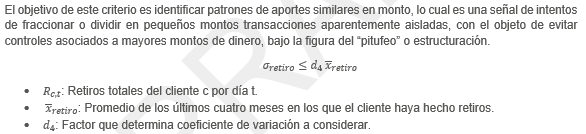

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>cant_minima_retiros</td>
      <td>5</td>
      <td>Cantidad mínima de retiros para evitar aplicar el criterio en rescates insuficientes</td>
    </tr>
    <tr>
      <td>$d_{3}$</td>
      <td>0.1</td>
      <td>Coeficiente de variación que relaciona que tan distinto es el promedio respecto a la desviación estándar para identificar rescates similares</td>
    </tr>
  </tbody>
</table>


In [74]:
cant_minima_retiros = 5
d_3 = 0.1

In [75]:
## COEFICIENTE DE VARIACION
df_grouped_R = df_combinado_R.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_rescates=('MONTO_CLP', 'mean'),
    std_rescates=('MONTO_CLP', 'std'),
    count_rescates=('MONTO_CLP', 'size')
).reset_index()

df_grouped_R['coef_var'] = df_grouped_R['std_rescates'] / df_grouped_R['promedio_rescates']
df_grouped_R['alerta'] = (df_grouped_R['coef_var'] <= d_3) & (df_grouped_R['count_rescates'] >= cant_minima_retiros)

# FILTRA LOS DE LA ALERTA
df_alerta_RETIROSSIMILARES = df_grouped_R[df_grouped_R['alerta']]
df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES.reset_index(drop=True)

In [76]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_RETIROSSIMILARES.shape[0]}\n",
      df_alerta_RETIROSSIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 5 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 1.4 % 
Cantidad de veces que se levanta la señal: 6
 MES
2023-07    1
2024-03    1
2024-05    2
2024-06    2
Freq: M, Name: count, dtype: int64


In [77]:
df_alerta_RETIROSSIMILARES = pd.merge(df_alerta_RETIROSSIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [78]:
df_alerta_RETIROSSIMILARES_color = df_alerta_RETIROSSIMILARES.copy()
############### COLOR ##################
unique_ids = df_alerta_RETIROSSIMILARES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_RETIROSSIMILARES_color = (
    df_alerta_RETIROSSIMILARES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_RETIROSSIMILARES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\283069810.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\283069810.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,promedio_rescates,std_rescates,count_rescates,coef_var,alerta,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2023-07,14122628-2,4933119.194980,51759.976987,5,0.010492,True,MATIAS RICARDO SILVA GONZALEZ,NATURAL,
1,2024-03,16370075-1,6553182.370200,635997.732826,6,0.097052,True,Andrés Adolfo Ovalle Andrews,NATURAL,
2,2024-05,16666615-5,4849212.037400,297933.987037,11,0.061440,True,HERNAN GUILLERMO MOLLER ZAVALLA,NATURAL,
3,2024-05,17669780-6,4952139.205100,8855.471416,7,0.001788,True,MARIO PORTILLA ESPINOZA,NATURAL,
4,2024-06,17601166-1,4959600.362257,24816.122656,6,0.005004,True,VICENTE NAVARRETE SIFRI,NATURAL,
5,2024-06,17669780-6,4764102.892537,369431.965302,8,0.077545,True,MARIO PORTILLA ESPINOZA,NATURAL,


#### 2. INCREMENTO EN LA FRECUENCIA DE RETIROS

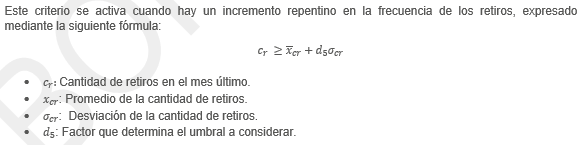

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>$d_{4}$</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_rescates</td>
      <td>5</td>
      <td>Cantidad mínima de rescates para el criterio</td>
    </tr>
    <tr>
      <td>$TH_{R}$</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [79]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_4 = 3
cant_min_rescates = 5
TH_R = 1.5

In [80]:
alertas_frecuencia_R = []

# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_R['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_R[df_grouped_R['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL MES n_meses
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR RESCATES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_rescates'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASAR AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # CALCULAR PROMEDIO Y DESVIACIÓN ESTÁNDAR DE RESCATES
        promedio_rescate = ultimos_n_meses_validos['count_rescates'].mean()
        std_rescate = ultimos_n_meses_validos['count_rescates'].std()
        
        # OBTENER CANTIDAD DE RESCATES DEL MES ACTUAL
        rescates_actual = df_cliente.iloc[i]['count_rescates']
        
        # ESTABLECER CONDICIÓN c_a ≥ x_ca + d_4 * σ_ca
        if rescates_actual > cant_min_rescates and rescates_actual > TH_R * (promedio_rescate + d_4 * std_rescate):
            alertas_frecuencia_R.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'rescates_actual': rescates_actual,
                'promedio_rescate': promedio_rescate,
                'std_rescate': std_rescate,
                'umbral': promedio_rescate + d_4 * std_rescate
            })

# CREAR DATAFRAME CON LAS ALERTAS
df_alerta_FRECUENCIARETIROS = pd.DataFrame(alertas_frecuencia_R)

In [81]:
df_alerta_FRECUENCIARETIROS = pd.merge(df_alerta_FRECUENCIARETIROS, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [82]:
df_alerta_FRECUENCIARETIROS

,MES,IDENTIFICADOR,rescates_actual,promedio_rescate,std_rescate,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-05,17669780-6,7,1.50,1.000000,4.500000,MARIO PORTILLA ESPINOZA,NATURAL,
1,2024-03,15641707-6,9,1.50,0.577350,3.232051,MATIAS EDUARDO GOLDSMITH DUENAS,NATURAL,
2,2024-07,15317930-1,9,1.75,0.957427,4.622281,JUAN CARLOS TRONCOSO PINO,NATURAL,


In [83]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIARETIROS.shape[0]}\n",
      df_alerta_FRECUENCIARETIROS.value_counts('MES').sort_index())

La cantidad de clientes son: 358  
Clientes con señal de alerta: 3 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.84 % 
Cantidad de veces que se levanta la señal: 3
 MES
2024-03    1
2024-05    1
2024-07    1
Freq: M, Name: count, dtype: int64


In [84]:
df_alerta_FRECUENCIARETIROS_color = df_alerta_FRECUENCIARETIROS.copy()
############### COLOR ##################
unique_ids = df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_FRECUENCIARETIROS_color = (
    df_alerta_FRECUENCIARETIROS_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_FRECUENCIARETIROS_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1875345218.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1875345218.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,rescates_actual,promedio_rescate,std_rescate,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-05,17669780-6,7,1.500000,1.000000,4.500000,MARIO PORTILLA ESPINOZA,NATURAL,
1,2024-03,15641707-6,9,1.500000,0.577350,3.232051,MATIAS EDUARDO GOLDSMITH DUENAS,NATURAL,
2,2024-07,15317930-1,9,1.750000,0.957427,4.622281,JUAN CARLOS TRONCOSO PINO,NATURAL,


## CRITERIO OPERACIONES

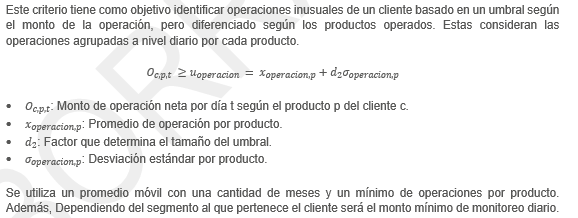

In [85]:
def asignar_O(row):
    return 1_000_000 if row['TIPO_PER'] == 'NATURAL' and row['RIESGO'] == 'PEP' else 2_000_000 if row['TIPO_PER'] == 'NATURAL' else 5_000_000


df_operaciones['COD_TIPO_OPERACION'].value_counts()

cod_tipo_op = ['FWDV'
'FWDC',
'COMPRA_OTC',
'VENTA',   
'VIFM',
'CIRVS',
'VIRVS',
'CIFM',
'COMPRA',
'VIRV',
'CIRV']     

In [86]:
df_operaciones = df_operaciones.copy()
df_operaciones = df_operaciones[df_operaciones['COD_TIPO_OPERACION'].isin(cod_tipo_op)]

# AGRUPAR OPERACIONES POR DIA Y MONTO PARA FILTRAR EL MONTO MINIMO DE OPERACION
df_diario = df_operaciones.groupby(['IDENTIFICADOR', 'FECHA_OPERACION', 'COD_SUB_CLASE_INSTRUMENTO']).agg(
    total_monto_diario=('MONTO', 'sum')
).reset_index()

In [87]:
df_diario = df_diario.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario['monto_min_monitoreo'] = df_diario.apply(asignar_O, axis=1, result_type='expand')

# FILTRADO
df_filtrado = df_diario[df_diario['total_monto_diario'] >= df_diario['monto_min_monitoreo']].copy()
df_filtrado['FECHA_OPERACION'] = pd.to_datetime(df_filtrado['FECHA_OPERACION'])  
df_filtrado['MES'] = df_filtrado['FECHA_OPERACION'].dt.to_period('M') 

df_filtrado['MES_NUM'] = df_filtrado['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_filtrado['MES_NUM'] = df_filtrado['MES_NUM'] - df_filtrado['MES_NUM'].min() + 1

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_filtrado = df_filtrado.sort_values(by=['IDENTIFICADOR', 'FECHA_OPERACION'])
df_filtrado['MES_NUM2'] = df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES']).ngroup() + 1

**PARAMETROS ESTADÍSTICA Y UMBRAL**

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_O</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_5$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_o$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>1.5</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [88]:
# PARÁMETRO PARA EL UMBRAL Y NÚMERO DE MESES
d_5 = 3.5
Nm_O = 4
th_o_N = 1.5
th_o_J = 2

In [89]:
resultados = []

# AGRUPAR por IDENTIFICADOR, COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR ULTIMOS Nm_O
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_O)]
        
        # ESTADÍSTICA
        promedio_operacion = ultimos_n_meses['total_monto_diario'].mean()
        std_operacion = ultimos_n_meses['total_monto_diario'].std()
        
        resultados.append({
            'IDENTIFICADOR': identificador,
            'COD_SUB_CLASE_INSTRUMENTO': cod_instrumento,
            'MES': mes_actual,
            'promedio_operacion': promedio_operacion,
            'std_operacion': std_operacion
        })


df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.drop_duplicates(subset=['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES'])

# PRIMEROS N MESES, 'promedio_operacion'  'std_operacion' a 'NaN' para cada IDENTIFICADOR y COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_resultados.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    indices = grupo.index[:Nm_O]
    df_resultados.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'

# CONVERTIR A NUMÉRICO PARA ERRORES
df_grouped_O = df_resultados.copy()
df_grouped_O['promedio_operacion'] = pd.to_numeric(df_grouped_O['promedio_operacion'], errors='coerce')
df_grouped_O['std_operacion'] = pd.to_numeric(df_grouped_O['std_operacion'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\2083550964.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'


**OBTENCIÓN UMBRAL**

In [90]:
df_grouped_O = pd.merge(df_grouped_O, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [91]:
df_muestra2[df_muestra2['IDENTIFICADOR'] == '16557897-K']

,IDENTIFICADOR,NOMBRE_CLIENTE,TIPO_PER,SEGMENTO,RIESGO
160,16557897-K,RODRIGO JOAQUÍN GÓMEZ RIVAS,NATURAL,NaN,PEP


In [92]:
df_grouped_O[df_grouped_O['IDENTIFICADOR'] == '16557897-k']

,IDENTIFICADOR,COD_SUB_CLASE_INSTRUMENTO,MES,promedio_operacion,std_operacion,NOMBRE_CLIENTE,TIPO_PER,RIESGO


In [94]:
alertas_operacion = []

# Agrupar por 'IDENTIFICADOR' y 'COD_SUB_CLASE_INSTRUMENTO'
for (id_cliente, cod_sub_clase), df_cliente in df_grouped_O.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)

    # ITERAR DESDE Nm_O HASTA FINAL DF
    for i in range(Nm_O, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        promedio_operacion = df_cliente.iloc[i]['promedio_operacion']   
        std_operacion = df_cliente.iloc[i]['std_operacion']
        tipo_per = df_cliente.iloc[i]['TIPO_PER']  # Obtener 'TIPO_PER'
        
        # APORTES MES ACTUAL
        operaciones_actuales_filtro = df_filtrado[
            (df_filtrado['MES'] == mes_actual) & 
            (df_filtrado['IDENTIFICADOR'] == id_cliente) & 
            (df_filtrado['COD_SUB_CLASE_INSTRUMENTO'] == cod_sub_clase)
        ]

        # ITERA SOBRE APORTES
        for _, operacion_fila in operaciones_actuales_filtro.iterrows():
            
            operacion_actual = operacion_fila['total_monto_diario']
            fecha_operacion = operacion_fila['FECHA_OPERACION']  # Obtener 'FECHA_OPERACION'
            
            # UMBRAL
            if std_operacion == 0:
                umbral = promedio_operacion * th_nstd  # THRESHOLD SIN STD
            else:
                if tipo_per == 'NATURAL':
                    umbral = th_o_N * (promedio_operacion + d_5 * std_operacion)  # NATURAL
                elif tipo_per == 'JURIDICA':
                    umbral = th_o_J * (promedio_operacion + d_5 * std_operacion)  # JURIDICA
            
            # OBTIENE APORTES SOBRE UMBRAL
            if operacion_actual > umbral:
                alertas_operacion.append({
                    'MES': mes_actual,
                    'FECHA_OPERACION': fecha_operacion, 
                    'IDENTIFICADOR': id_cliente,
                    'COD_SUB_CLASE_INSTRUMENTO': cod_sub_clase,
                    'operacion_actual': operacion_actual,
                    'promedio_operacion': promedio_operacion,
                    'std_operacion': std_operacion,
                    'umbral': umbral
                })

# Crear DataFrame de alertas
df_alerta_OPERACIONSUPERAUMBRAL = pd.DataFrame(alertas_operacion)


In [95]:
df_alerta_OPERACIONSUPERAUMBRAL =df_alerta_OPERACIONSUPERAUMBRAL.rename(columns={"COD_SUB_CLASE_INSTRUMENTO": "producto"})

In [96]:
df_alerta_OPERACIONSUPERAUMBRAL = pd.merge(df_alerta_OPERACIONSUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ') #debug

In [97]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_OPERACIONSUPERAUMBRAL.shape[0]}\n",
      df_alerta_OPERACIONSUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 38 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 10.61 % 
Cantidad de veces que se levanta la señal: 65
 MES
2023-10     2
2023-11     1
2024-01     3
2024-02     1
2024-03     4
2024-04     8
2024-05     6
2024-06     8
2024-07    13
2024-08     4
2024-09    15
Freq: M, Name: count, dtype: int64


In [98]:
df_alerta_OPERACIONSUPERAUMBRAL_color = df_alerta_OPERACIONSUPERAUMBRAL.copy()
################# COLOR
unique_ids = df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_umbral_operacion(row):
    monto_vs_umbral = row['operacion_actual'] / row['umbral']
    if monto_vs_umbral > 2:
        return ['background-color: red'] * len(row)  
    elif monto_vs_umbral > 1.6:
        return ['background-color: orange'] * len(row)  
    else:
        return [''] * len(row)

df_alerta_OPERACIONSUPERAUMBRAL_color = (
    df_alerta_OPERACIONSUPERAUMBRAL_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_umbral_operacion, axis=1, subset=['operacion_actual', 'umbral'])
)

df_alerta_OPERACIONSUPERAUMBRAL_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\31009007.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\31009007.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,FECHA_OPERACION,IDENTIFICADOR,producto,operacion_actual,promedio_operacion,std_operacion,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-09,2024-09-09 00:00:00,13082416-1,CFI,49760133.000000,4166724.000000,1047990.173671,11752034.411772,JUAN PÉREZ RETAMALES,NATURAL,
1,2024-04,2024-04-15 00:00:00,13082416-1,ETF,386038685.000000,13710484.870968,40532734.674782,233362584.349058,JUAN PÉREZ RETAMALES,NATURAL,
2,2024-04,2024-04-24 00:00:00,13082416-1,ETF,317570598.000000,13710484.870968,40532734.674782,233362584.349058,JUAN PÉREZ RETAMALES,NATURAL,
3,2024-09,2024-09-12 00:00:00,13952791-7,CFI,64956238.000000,5375115.571429,2296341.090318,20118464.081311,IGNACIO ANTONIO VÉJAR MAYORA,NATURAL,
4,2024-04,2024-04-16 00:00:00,14010714-K,CFI,31427889.000000,4710018.888889,1845494.253048,16753873.161838,FELIPE HARTWIG LANGEVIN,NATURAL,
5,2024-05,2024-05-07 00:00:00,14010714-K,SPOT_NAC,18487962.000000,5223940.111111,1769986.572851,17128339.674133,FELIPE HARTWIG LANGEVIN,NATURAL,
6,2024-07,2024-07-08 00:00:00,14583955-6,ACC,10687834.000000,2818528.833333,779473.485250,8320029.047564,ROBINSON ALEJANDRO CAÑETE SEPÚLVEDA,NATURAL,
7,2024-07,2024-07-17 00:00:00,15040585-8,ACC,112971410.000000,14486114.933333,11585405.143602,82552549.403910,Jose Antonio Campos Veliz,NATURAL,
8,2024-07,2024-07-18 00:00:00,15040585-8,ACC,82672324.000000,14486114.933333,11585405.143602,82552549.403910,Jose Antonio Campos Veliz,NATURAL,
9,2024-07,2024-07-22 00:00:00,15040585-8,ACC,103793484.000000,14486114.933333,11585405.143602,82552549.403910,Jose Antonio Campos Veliz,NATURAL,


## CRITERIO PATRIMONIO

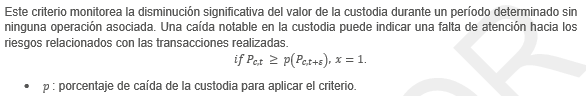

In [99]:
custodia_detalle_test = df_custodia_detalle.copy()
operaciones_consolidado_test = df_operaciones.copy()

# DATE TIME
custodia_detalle_test['fecha_cierre'] = pd.to_datetime(custodia_detalle_test['fecha_cierre'])
operaciones_consolidado_test['FECHA_OPERACION'] = pd.to_datetime(operaciones_consolidado_test['FECHA_OPERACION'])

# CAIDA VALOR
p = 7/100
pat_min = 4_000_000
caida_min = 1_000_000

# AÑO MES
custodia_detalle_test['MES'] = custodia_detalle_test['fecha_cierre'].dt.to_period('M')
operaciones_consolidado_test['MES'] = operaciones_consolidado_test['FECHA_OPERACION'].dt.to_period('M')

# CUSTODIA VALORIZADA DIARIA
suma_valor_diario = custodia_detalle_test.groupby(['IDENTIFICADOR', 'fecha_cierre']).agg(
    VALOR_MERCADO_DIA=('VALOR_MERCADO_CLP', 'sum')
).reset_index()

suma_valor_diario_minimo = suma_valor_diario[suma_valor_diario['VALOR_MERCADO_DIA'] > pat_min]

# OBTENER VALOR INICIO Y FIN DE MES
custodias_inicio_fin_mes = suma_valor_diario_minimo.groupby(['IDENTIFICADOR', suma_valor_diario_minimo['fecha_cierre'].dt.to_period('M')]).agg(
    VALOR_INICIO_MES=('VALOR_MERCADO_DIA', 'first'),
    VALOR_FIN_MES=('VALOR_MERCADO_DIA', 'last'),
    FECHA_INICIO=('fecha_cierre', 'first'),
    FECHA_FIN=('fecha_cierre', 'last')
).reset_index()

# Renombrar la columna de periodo a AÑO_MES para hacer el merge
custodias_inicio_fin_mes.rename(columns={'fecha_cierre': 'MES'}, inplace=True)

# MERGE CON OPERACIONES PARA OBTENER LAS OPERACIONES DENTRO DEL MISMO PERÍODO
custodias_con_operaciones = pd.merge(custodias_inicio_fin_mes, 
                                     operaciones_consolidado_test[['IDENTIFICADOR', 'MES', 'FECHA_OPERACION']],
                                     on=['IDENTIFICADOR', 'MES'], 
                                     how='left')

# CAIDA EN VALOR
custodias_con_operaciones['CAIDA_VALOR'] = (custodias_con_operaciones['VALOR_INICIO_MES'] - custodias_con_operaciones['VALOR_FIN_MES']) 
# FILTRAR CASOS DONDE LA CAÍDA DE VALOR SEA MAYOR O IGUAL AL 20% Y NO HAYA OPERACIONES EN ESE PERÍODO
resultados = custodias_con_operaciones[
    (custodias_con_operaciones['CAIDA_VALOR'] >= custodias_con_operaciones['VALOR_INICIO_MES']*p) &
    (custodias_con_operaciones['FECHA_OPERACION'].isna())
]


df_caida_significativa = resultados[['IDENTIFICADOR', 'VALOR_INICIO_MES', 'VALOR_FIN_MES', 'FECHA_INICIO', 'FECHA_FIN', 'CAIDA_VALOR']]
df_caida_significativa = df_caida_significativa[df_caida_significativa['CAIDA_VALOR'] > caida_min]

In [100]:
df_caida_significativa = pd.merge(df_caida_significativa, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [101]:
df_caida_significativa_color = df_caida_significativa.copy()
############### COLOR ##################
unique_ids = df_caida_significativa_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_caida_significativa_color = (
    df_caida_significativa_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_caida_significativa_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1664451877.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\1664451877.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,IDENTIFICADOR,VALOR_INICIO_MES,VALOR_FIN_MES,FECHA_INICIO,FECHA_FIN,CAIDA_VALOR,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,17401828-6,69656682,64616572,2024-08-01 00:00:00,2024-08-31 00:00:00,5040110,GONZALO ELIZALDE PEÑA,NATURAL,



# LOGICA  NIVELES DE ALERTA

In [102]:
df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M')

In [103]:
peso_alertas = {
    2: ['Señal_Aporte_Diario_Grande', 'df_alerta_FRECUENCIARETIROS', 'df_aporte_mayor_custodia', 'df_alerta_APORTESIMILARES', 'Señal_Aporte_Mensual_Grande'], 
    3: ['df_alerta_FRECUENCIAAPORTES', 'df_caida_significativa', 'df_alerta_RETIROSSIMILARES'],
    5: ['df_alerta_APORTESUPERAUMBRAL', 'df_alerta_OPERACIONSUPERAUMBRAL', 'df_monto_inmovilizado'],
}

alert_map = {
    'df_alerta_APORTESUPERAUMBRAL': (df_alerta_APORTESUPERAUMBRAL, 'APORTE SUPERA UMBRAL'),
    'df_alerta_APORTESIMILARES': (df_alerta_APORTESIMILARES, 'APORTES SIMILARES'),
    'df_aporte_mayor_custodia': (df_aporte_mayor_custodia, 'APORTE MAYOR A CUSTODIA'),
    
    'Señal_Aporte_Diario_Grande': (Señal_Aporte_Diario_Grande, 'APORTES DIARIO ELEVADO'),
    'Señal_Aporte_Mensual_Grande': (Señal_Aporte_Mensual_Grande, 'APORTES MENSUAL ELEVADO'),

    'df_monto_inmovilizado': (df_monto_inmovilizado, 'APORTE INMOVILIZADO'),
    
    'df_alerta_FRECUENCIAAPORTES': (df_alerta_FRECUENCIAAPORTES, 'AUMENTO FRECUENCIA APORTES'),
    'df_alerta_RETIROSSIMILARES': (df_alerta_RETIROSSIMILARES, 'RETIROS SIMILARES'),
    'df_alerta_FRECUENCIARETIROS': (df_alerta_FRECUENCIARETIROS, 'AUMENTO FRECUENCIA RETIROS'),
    
    'df_alerta_OPERACIONSUPERAUMBRAL': (df_alerta_OPERACIONSUPERAUMBRAL, 'OPERACION SUPERA UMBRAL'),
    'df_caida_significativa': (df_caida_significativa, 'CAIDA SIGNIFICATIVA CUSTODIA')
}


results = []
for weight, alerts in peso_alertas.items():
    for alert in alerts:
        if alert in alert_map:
            dataframe, description = alert_map[alert]
            for index, row in dataframe.iterrows():
                results.append({
                    'IDENTIFICADOR': row['IDENTIFICADOR'],
                    'MES': row['MES'],
                    'SCORE': weight,
                    'DATAFRAME': description
                })

In [104]:
df_results = pd.DataFrame(results)
df_results_METODO1 = pd.pivot_table(df_results, values='SCORE', index=['IDENTIFICADOR','DATAFRAME'],columns=['MES'], aggfunc='sum')
df_results_METODO1 = df_results_METODO1.reset_index()
df_results_METODO1 = df_results_METODO1.fillna(0)
df_results_METODO1 = df_results_METODO1.rename_axis(None, axis=1)

In [105]:
######### CREACION MESES ADICIONALES

df_results_METODO2 = df_results_METODO1.copy()

all_months = pd.date_range(start='2022-01', end='2024-11', freq='MS').strftime('%Y-%m').tolist()
df_results_METODO2 = df_results_METODO2.set_index(['IDENTIFICADOR', 'DATAFRAME'])

df_results_METODO2.columns = df_results_METODO2.columns.astype(str)

for month in all_months:
    if month not in df_results_METODO2.columns:
        df_results_METODO2[month] = 0.0

# Volver a organizar las columnas de meses en orden cronológico
months_columns = sorted([col for col in df_results_METODO2.columns if col not in ['IDENTIFICADOR', 'DATAFRAME']])
# Reindexar el DataFrame incluyendo las columnas en orden
df_results_METODO2 = df_results_METODO2.reindex(columns=months_columns)
# Resetear el índice para volver al formato original
df_results_METODO2 = df_results_METODO2.reset_index()

df_results_METODO2.head(5)

,IDENTIFICADOR,DATAFRAME,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
0,10074072-9,APORTES SIMILARES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10577379-K,APORTE SUPERA UMBRAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,11277742-3,APORTE SUPERA UMBRAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11277742-3,AUMENTO FRECUENCIA APORTES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11833342-K,APORTE MAYOR A CUSTODIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [106]:
df_results = df_results_METODO2.copy()
months = df_results_METODO2.columns[2:]

for index, row in df_results_METODO2.iterrows():
    for i, month in enumerate(months[:-2]):
        if row[month] != 0:
            df_results.at[index, months[i+1]] += row[month]
            df_results.at[index, months[i+2]] += row[month]


display(df_results.head(5))

,IDENTIFICADOR,DATAFRAME,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
0,10074072-9,APORTES SIMILARES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10577379-K,APORTE SUPERA UMBRAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0
2,11277742-3,APORTE SUPERA UMBRAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11277742-3,AUMENTO FRECUENCIA APORTES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11833342-K,APORTE MAYOR A CUSTODIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0


In [107]:
df_results_METODO2_sum = df_results.groupby('IDENTIFICADOR').sum().reset_index()
del df_results_METODO2_sum['DATAFRAME']

display(df_results_METODO2_sum.head(5))

,IDENTIFICADOR,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
0,10074072-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10577379-K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0
2,11277742-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11833342-K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0
4,11862862-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
df_results_METODO2_sum.sample()

,IDENTIFICADOR,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
95,19639680-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0


In [109]:
resultados = []

# Combinar los DataFrames para obtener la información de riesgo de cada cliente
df_combinado = pd.merge(df_results_METODO2_sum, df_muestra2[['IDENTIFICADOR', 'RIESGO']], on='IDENTIFICADOR', how='left')

# NIVELES Y EVALUACIÓN
for index, row in df_combinado.iterrows():
    identificador = row['IDENTIFICADOR']
    riesgo = row['RIESGO']
    
    for mes in df_combinado.columns[1:-1]:  # Evitamos la columna RIESGO en las fechas
        puntaje = row[mes]
        puntaje = pd.to_numeric(puntaje, errors='coerce')
        
        # Flujo diferenciado basado en el riesgo
        if pd.notna(puntaje) and puntaje != 0:
            if riesgo in ['PEP', 'JUDICIAL', 'ALTO']:
                if puntaje >= 5:
                    estado = 'REVISION'
                else:
                    estado = 'MONITOREO' if 1 <= puntaje < 5 else 'HALLAZGO'
            else:
                # Para clientes sin riesgo específico (NaN)
                if 1 <= puntaje <= 4:
                    estado = 'HALLAZGO'
                elif 5 <= puntaje <= 9:
                    estado = 'MONITOREO'
                else:
                    estado = 'REVISION'
            
            resultados.append({
                'IDENTIFICADOR': identificador,
                'MES': mes,
                'PUNTAJE': puntaje,
                'ESTADO': estado,
                'RIESGO': riesgo
            })


df_resultados_estado = pd.DataFrame(resultados)

# Aplicar reglas adicionales para ajustar estados basados en secuencias de "HALLAZGO" o "MONITOREO"
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    group = group.reset_index(drop=True)
    
    for i in range(len(group) - 3):  # Aseguramos que haya al menos 4 registros consecutivos
        subset = group.iloc[i:i+4]  # Tomamos 4 filas consecutivas
        
        # Si todos los estados en este grupo son HALLAZGO o MONITOREO y la suma de los puntajes supera 26, cambiar a REVISION
        if subset['ESTADO'].isin(['HALLAZGO', 'MONITOREO']).all() and subset['PUNTAJE'].sum() > 26:
            df_resultados_estado.loc[(df_resultados_estado['IDENTIFICADOR'] == identificador) & 
                                     (df_resultados_estado['MES'] == subset.iloc[3]['MES']), 'ESTADO'] = 'REVISION'

# Resultado final
#filtered_df = df_resultados_estado


In [110]:
############################### FILTRA REVISION PARA NO REPETIR ALERTA
rows_to_keep = []

# Iterar sobre cada grupo de IDENTIFICADOR
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    # Ordenar el grupo por MES
    group = group.sort_values(by='MES')
    # Iterar sobre las filas del grupo
    previous_row = None
    for index, row in group.iterrows():
        if row['ESTADO'] == 'REVISION':
            if previous_row is None or row['PUNTAJE'] != previous_row['PUNTAJE']:
                rows_to_keep.append(row)
            previous_row = row
        if row['ESTADO'] == 'MONITOREO': 
            rows_to_keep.append(row)
        if row['ESTADO'] == 'HALLAZGO': 
            rows_to_keep.append(row)

############################### FILTRA REVISION PARA NO REPETIR ALERTA
filtered_df = pd.DataFrame(rows_to_keep)
filtered_df = filtered_df.reset_index(drop=True)
df_filtered = filtered_df.copy()

In [111]:
df_filtered = pd.merge(df_filtered, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER']], on='IDENTIFICADOR', how='left').fillna(' ')

# ANALISIS ALERTAS GENERADAS

In [112]:
df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]
df_filtrado_dof = df_rev_mon.drop_duplicates(subset=['IDENTIFICADOR'], keep='first').reset_index(drop=True)

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_19520\3185496423.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]


In [113]:
c1 = df_filtrado_dof['ESTADO'] == 'REVISION'
c2 = df_filtrado_dof['ESTADO'] == 'MONITOREO'


df_analisis = df_filtrado_dof[c1|c2].sort_values(by='MES').reset_index(drop=True)

In [114]:
df_DATOS_clientes[df_DATOS_clientes['IDENTIFICADOR'] == '16557897-k']

,Unnamed: 0,NUM_CUENTA,DSC_CUENTA,ESTADO_CUENTA,COD_MONEDA,FECHA_OPERATIVA,NOMBRE_CLIENTE,NOMBRE_ASESOR,DSC_PERFIL_RIESGO,FECHA_NACIMIENTO,IDENTIFICADOR,COD_PAIS,PROFESION,EMPLEADOR,CARGO


In [115]:
df_analisis

,IDENTIFICADOR,MES,PUNTAJE,ESTADO,RIESGO,NOMBRE_CLIENTE,TIPO_PER
0,14122628-2,2023-07,5.0,MONITOREO,,MATIAS RICARDO SILVA GONZALEZ,NATURAL
1,18934898-3,2023-10,10.0,REVISION,,CAMILA MANETTI ARECHAVALA,NATURAL
2,15383710-4,2023-11,12.0,REVISION,,PABLO RAMÍREZ CALVO,NATURAL
3,18933286-6,2024-01,5.0,MONITOREO,,JOSEFINA VALDES EDWARDS,NATURAL
4,16819976-7,2024-01,5.0,MONITOREO,,FERNANDO ESTAY PEREZ,NATURAL
5,11277742-3,2024-02,13.0,REVISION,,FERNANDO RODOLFO URRA HERRERA,NATURAL
6,17407729-0,2024-02,10.0,REVISION,,TERESITA ALESSANDRI CRUZAT,NATURAL
7,96585520-3,2024-03,10.0,REVISION,,ALBI S.A,JURÍDICA
8,17699384-7,2024-03,10.0,REVISION,,FRANCISCO LATHROP VALENZUELA,NATURAL
9,15317930-1,2024-03,13.0,REVISION,,JUAN CARLOS TRONCOSO PINO,NATURAL


In [160]:
df_resultados.sample()

,IDENTIFICADOR,COD_SUB_CLASE_INSTRUMENTO,MES,promedio_operacion,std_operacion
4911,9448597-5,SPOT_NAC,2024-08,5000000.0,0.0


In [159]:

df_analisis['MES'] = pd.to_datetime(df_analisis['MES'], format='%Y-%m')

df_analisis['first_day_of_month'] = df_analisis['MES'].dt.to_period('M').dt.start_time


df_filtered = df_custodia_consolidado.merge(df_analisis[['IDENTIFICADOR', 'first_day_of_month']], 
                                            on='IDENTIFICADOR')

df_filtered = df_filtered[df_filtered['fecha_cierre'] == df_filtered['first_day_of_month']].reset_index(drop=True)

display(df_filtered[df_filtered['VALOR_MERCADO_CLP'] >= 10_000_000] )

,IDENTIFICADOR,fecha_cierre,VALOR_MERCADO_CLP,first_day_of_month
0,10577379-K,2024-09-01,44121153,2024-09-01
1,11277742-3,2024-02-01,162100133,2024-02-01
2,13256647-K,2024-08-01,70640671,2024-08-01
3,13668051-K,2024-09-01,46245713,2024-09-01
4,13952791-7,2024-09-01,68087810,2024-09-01
6,14583955-6,2024-08-01,39706058,2024-08-01
7,15040585-8,2024-07-01,58314000,2024-07-01
8,15317372-9,2024-04-01,81579738,2024-04-01
9,15317930-1,2024-03-01,19050429,2024-03-01
10,15580648-6,2024-03-01,18686222,2024-03-01


In [130]:
id = '18933906-2'
mes = '2024-01'
display(df_grouped_A[(df_grouped_A['IDENTIFICADOR'] == id) & (df_grouped_A['MES'] == mes)])
display(df_grouped_O[(df_grouped_O['IDENTIFICADOR'] == id) & (df_grouped_O['MES'] == mes)])


,MES,IDENTIFICADOR,promedio_aportes,std_aportes,count_aportes,coef_var,alerta
677,2024-01,18933906-2,4.230769e+06,1.772068e+06,13,0.418852,False


,IDENTIFICADOR,COD_SUB_CLASE_INSTRUMENTO,MES,promedio_operacion,std_operacion,NOMBRE_CLIENTE,TIPO_PER,RIESGO
1519,18933906-2,CFI,2024-01,,,ALFONSO VALENZUELA ITURRIAGA,NATURAL,


In [117]:
## Primer día del mes de la alerta ver custodia del cliente,

#Tener IDENTIFICADOR, mes de alerta y sucesivas consultas con la custodia y mes
#y o ver estadísticas respecto al mes de la alerta: promedio de operación por producto, Promedio de aportes últimos 4 meses, aporte máximo e

In [118]:
### ESTADISTICA ALERTAS
revision = df_filtered[df_filtered['ESTADO'] == 'REVISION'].reset_index(drop=True)
monitoreo = df_filtered[df_filtered['ESTADO'] == 'MONITOREO'].reset_index(drop=True)
hallazgo = df_filtered[df_filtered['ESTADO'] == 'HALLAZGO'].reset_index(drop=True)


print(f"Cantidad de clientes con señales de alerta: {df_filtered['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes que se les asigna REVISIÓN: {revision['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna MONITOREO: {monitoreo['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna HALLAZGO: {hallazgo['IDENTIFICADOR'].nunique()}  \n" 
     
     )

Cantidad de clientes con señales de alerta: 129  
Clientes que se les asigna REVISIÓN: 28  
Clientes que se les asigna MONITOREO: 41  
Clientes que se les asigna HALLAZGO: 85  



In [119]:
resultado = df_filtered.groupby(['MES', 'ESTADO']).size().reset_index(name='Count')
pivot_table = resultado.pivot_table(index='MES', columns='ESTADO', values='Count', fill_value=0)

In [120]:
df_filtered_color = df_filtered.copy()

def color_estado(val):
    colors = {
        'REVISION': 'color: red',
        'MONITOREO': 'color: orange',
        'HALLAZGO': 'color: green'
    }
    return colors.get(val, '')


df_filtered_color = df_filtered_color.style.format({
    'PUNTAJE': '{:.1f}'
}).applymap(color_estado, subset=['ESTADO'])


#df_filtered_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_11484\3274092869.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(color_estado, subset=['ESTADO'])


# INTERFAZ SEÑALES DE ALERTA 

In [121]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
#df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')

In [122]:
#del df_DATOS_clientes['Unnamed: 0']

# EXTRAER INFO PERSONAL
info_personal_cols = ['NOMBRE_CLIENTE', 'FECHA_NACIMIENTO', 'IDENTIFICADOR', 'COD_PAIS', 'PROFESION', 'EMPLEADOR', 'CARGO']
df_info_personal = df_DATOS_clientes[info_personal_cols].drop_duplicates(subset='IDENTIFICADOR')

# EXTRAER DATOS DE CUENTAS
datos_cuentas_cols = ['IDENTIFICADOR','NUM_CUENTA', 'NOMBRE_ASESOR', 'DSC_CUENTA', 'ESTADO_CUENTA', 'COD_MONEDA', 'FECHA_OPERATIVA']
df_datos_cuentas = df_DATOS_clientes[datos_cuentas_cols]

In [123]:
class AlertaBase:
    def __init__(self, df_alerta, df_combinado, file_suffix):
        self.df_alerta = df_alerta
        self.df_combinado = df_combinado
        self.file_suffix = file_suffix

    def buscar_identificador(self, identificador):
        """Busca en el DataFrame de alerta por identificador."""
        return self.df_alerta[self.df_alerta['IDENTIFICADOR'] == identificador]

    def ver_operaciones(self, identificador, mes_alerta):
        """Obtiene las operaciones relacionadas con el identificador y el mes de alerta."""
        return self.df_combinado[(self.df_combinado['IDENTIFICADOR'] == identificador) & (self.df_combinado['MES'].isin(mes_alerta))]

### V NUEVO

### V ANTIGUA

In [124]:
class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("SEÑALES DE ALERTA MONITOREO TRANSACCIONAL")
        self.geometry("1500x700")

        self.configure(bg="#E8ECEF")  # Color azul claro como fondo
        
        # INICIALIZAR ALERTAS
        self.alertas = {
            'APORTE SUPERA UMBRAL': AlertaBase(df_alerta_APORTESUPERAUMBRAL, df_combinado_A, 'APORTE SUPERA UMBRAL'),
            'APORTES SIMILARES': AlertaBase(df_alerta_APORTESIMILARES, df_combinado_A, 'APORTES SIMILARES'),
            'AUMENTO FRECUENCIA DE APORTES': AlertaBase(df_alerta_FRECUENCIAAPORTES, df_combinado_A, 'AUMENTO FRECUENCIA DE APORTES'),
            
            'APORTES DIARIO ELEVADO': AlertaBase(Señal_Aporte_Diario_Grande, df_combinado_A, 'APORTES DIARIO ELEVADO'),
            'APORTES MENSUAL ELEVADO': AlertaBase(Señal_Aporte_Mensual_Grande, df_combinado_A, 'APORTES MENSUAL ELEVADO'),
    
            'APORTE INMOVILIZADO': AlertaBase(df_monto_inmovilizado, df_saldo_caja, 'APORTE INMOVILIZADO'),
            'ALERTA RETIROS SIMILARES': AlertaBase(df_alerta_RETIROSSIMILARES, df_combinado_R, 'ALERTA RETIROS_SIMILARES'),
            'AUMENTO FRECUENCIA DE RETIROS': AlertaBase(df_alerta_FRECUENCIARETIROS, df_combinado_R, 'SEÑAL AUMENTO FRECUENCIA DE RETIROS'),
            'CAIDA PATRIMONIO': AlertaBase(df_caida_significativa, df_custodia_detalle, 'CAIDA PATRIMONIO'),
            'UMBRAL OPERACIONES': AlertaBase(df_alerta_OPERACIONSUPERAUMBRAL, df_operaciones, 'UMBRAL OPERACIONES'),
            'APORTE MAYOR CUSTODIA': AlertaBase(df_aporte_mayor_custodia, df_combinado_A, 'APORTE MAYOR CUSTODIA'),
            
            
        }

        # Carga de logos
        self.logo_gpi = tk.PhotoImage(file="Logo_gpi.png")

        # Creación de los widgets de la interfaz
        self.create_widgets()

    def create_widgets(self):
        """Crea y ubica todos los widgets de la interfaz gráfica."""
        # Imágenes
        self.logo_gpi_label = tk.Label(self, image=self.logo_gpi)
        self.logo_gpi_label.place(x=240, y=25)

        # Campo de entrada para el RUT del cliente
        self.input_field = ttk.Entry(self)
        self.input_field.insert(0, "  Ingresa RUT cliente")
        self.input_field.place(x=30, y=240, width=120, height=30)

        # Botón para buscar identificador
        self.search_button = ttk.Button(self, text="VER", command=self.buscar_identificador)
        self.search_button.place(x=170, y=240, width=40, height=30)

        # Botón para ver todas las alertas
        self.ver_todas_alertas_button = ttk.Button(self, text="Ver todas las señales de alerta", command=self.ver_todas_alertas)
        self.ver_todas_alertas_button.place(x=30, y=200, width=200, height=30)

        # Botón adicional para mostrar df_filtered
        self.ver_df_filtered_button = ttk.Button(self, text="Ver todas las alertas filtradas", command=self.mostrar_df_filtered)
        self.ver_df_filtered_button.place(x=30, y=320, width=200, height=30)

        # Campo de texto para mostrar resultados
        self.result_field = tk.Text(self, height=62, width=170, state='disabled')
        self.result_field.place(x=230, y=50)

        # Botón para descargar operaciones
        self.ver_operaciones_button = ttk.Button(self, text="Descargar Operaciones", command=self.ver_operaciones, state='disabled')
        self.ver_operaciones_button.place(x=30, y=280, width=180, height=30)

        # Campo de entrada para el MES
        self.mes_input = ttk.Entry(self)
        self.mes_input.insert(0, "  Ingresa MES: YYYY-MM")
        self.mes_input.place(x=30, y=400, width=160, height=30)

        # Botones para filtrar por ESTADO y MES
        self.hallazgo_button = ttk.Button(self, text="Hallazgo", command=self.mostrar_hallazgo_por_mes)
        self.hallazgo_button.place(x=30, y=440, width=100, height=30)

        self.monitoreo_button = ttk.Button(self, text="Monitoreo", command=self.mostrar_monitoreo_por_mes)
        self.monitoreo_button.place(x=30, y=480, width=100, height=30)

        self.revision_button = ttk.Button(self, text="Revision", command=self.mostrar_revision_por_mes)
        self.revision_button.place(x=30, y=520, width=100, height=30)

        ### ADICIONAL
        # KYC
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Estado KYC: ")
        self.additional_input.place(x=1610, y=250, width=150, height=50)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text
        
        # TEXTO
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Comentarios: ")
        self.additional_input.place(x=1610, y=320, width=250, height=150)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text

        # FECHA REVISION
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Fecha revisión: ")
        self.additional_input.place(x=1610, y=490, width=200, height=30)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text

    def buscar_identificador(self):
        """Busca el identificador y muestra las alertas relacionadas."""
        identificador = self.input_field.get().strip()
        if not identificador:
            self.result_field.config(state='normal')
            self.result_field.delete(1.0, tk.END)
            self.result_field.insert(tk.END, "Por favor, ingresa un identificador válido.")
            self.result_field.config(state='disabled')
            return

        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        alerta_activa = False
        self.alertas_resultados = {}
        for nombre_alerta, alerta in self.alertas.items():
            resultado = alerta.buscar_identificador(identificador)
            if not resultado.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{resultado.to_string(index=False)}\n\n")
                alerta_activa = True
                self.alertas_resultados[nombre_alerta] = alerta

        if alerta_activa:
            self.result_field.insert(tk.END, "SEÑALES DE ALERTA")
            self.ver_operaciones_button.config(state='normal')
            self.identificador_actual = identificador
        else:
            self.result_field.insert(tk.END, "No se encontró alerta para este identificador.")
            self.ver_operaciones_button.config(state='disabled')

        self.result_field.config(state='disabled')

    def ver_todas_alertas(self):
        """Muestra todas las alertas en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        for nombre_alerta, alerta in self.alertas.items():
            if not alerta.df_alerta.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{alerta.df_alerta.to_string(index=False)}\n\n")

        self.result_field.config(state='disabled')

    def mostrar_df_filtered(self):
        """Muestra el DataFrame df_filtered en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        if not df_filtered.empty:
            self.result_field.insert(tk.END, f"df_filtered:\n{df_filtered.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, "No hay datos en df_filtered para mostrar.")

        self.result_field.config(state='disabled')

    def obtener_df_filtrado_por_mes(self):
        """Filtra df_filtered según el mes especificado."""
        mes = self.mes_input.get().strip()
        if not mes:
            return pd.DataFrame()  # Retorna un DataFrame vacío si no hay mes

        df_filtrado_por_mes = df_filtered[df_filtered['MES'] == mes]
        return df_filtrado_por_mes

    def mostrar_hallazgo_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'HALLAZGO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_hallazgo = df_mes[df_mes['ESTADO'] == 'HALLAZGO']
        
        if not df_hallazgo.empty:
            self.result_field.insert(tk.END, f"HALLAZGO ({self.mes_input.get()}):\n{df_hallazgo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'HALLAZGO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_monitoreo_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'MONITOREO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_monitoreo = df_mes[df_mes['ESTADO'] == 'MONITOREO']
        
        if not df_monitoreo.empty:
            self.result_field.insert(tk.END, f"MONITOREO ({self.mes_input.get()}):\n{df_monitoreo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'MONITOREO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_revision_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'REVISION' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_revision = df_mes[df_mes['ESTADO'] == 'REVISION']
        
        if not df_revision.empty:
            self.result_field.insert(tk.END, f"REVISION ({self.mes_input.get()}):\n{df_revision.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'REVISION' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def ver_operaciones(self):
            """Genera un archivo Excel con las operaciones y alertas para el identificador actual."""
            identificador = self.identificador_actual
            with pd.ExcelWriter(f'Operaciones_{identificador}.xlsx', engine='xlsxwriter') as writer:
        
                # Filtra la información del cliente
                df_info_personal_cliente = df_info_personal[df_info_personal['IDENTIFICADOR'] == identificador]
                df_datos_cuenta_cliente = df_datos_cuentas[df_datos_cuentas['IDENTIFICADOR'] == identificador]
                
                # Escribe df_info_personal_cliente en la primera hoja
                df_info_personal_cliente.to_excel(writer, sheet_name='Cliente_Info', index=False, startrow=0)
                
                # Agrega dos filas en blanco antes de escribir df_datos_cuenta_cliente
                startrow = len(df_info_personal_cliente) + 2
                df_datos_cuenta_cliente.to_excel(writer, sheet_name='Cliente_Info', index=False, startrow=startrow)
        
                workbook = writer.book
                cliente_worksheet = writer.sheets['Cliente_Info']
                
                # Formateo de la hoja de cliente
                header_format = workbook.add_format({
                    'bold': True,
                    'text_wrap': True,
                    'valign': 'top',
                    'fg_color': '#022596',
                    'font_color': 'white',
                    'border': 1
                })
                
                # Escribe los encabezados para df_info_personal_cliente
                for col_num, value in enumerate(df_info_personal_cliente.columns.values):
                    cliente_worksheet.write(0, col_num, value, header_format)
                cliente_worksheet.set_default_row(20)
                cliente_worksheet.set_column(0, len(df_info_personal_cliente.columns) - 1, 20)
                
                # Escribe los encabezados para df_datos_cuenta_cliente
                for col_num, value in enumerate(df_datos_cuenta_cliente.columns.values):
                    cliente_worksheet.write(startrow, col_num, value, header_format)
                cliente_worksheet.set_column(0, len(df_datos_cuenta_cliente.columns) - 1, 20)
        
                # Operaciones específicas por tipo de alerta
                for nombre_alerta, alerta in self.alertas_resultados.items():
                    mes_alerta = alerta.df_alerta.loc[alerta.df_alerta['IDENTIFICADOR'] == identificador, 'MES'].values
                    df_operaciones = alerta.ver_operaciones(identificador, mes_alerta)
                    if not df_operaciones.empty:
                        df_operaciones = df_operaciones.sort_values(by='FECHA_MOVIMIENTO')
                        sheet_name = f'{nombre_alerta}_{identificador}'[:31]  # Limitar nombre de la hoja a 31 caracteres
                        df_operaciones.to_excel(writer, sheet_name=sheet_name, index=False)
                        
                        worksheet = writer.sheets[sheet_name]
                        for col_num, value in enumerate(df_operaciones.columns.values):
                            worksheet.write(0, col_num, value, header_format)
                        worksheet.set_default_row(20)
                        worksheet.set_column(0, len(df_operaciones.columns) - 1, 20)
            
            # Actualiza el campo de texto con el mensaje de confirmación
            self.result_field.config(state='normal')
            self.result_field.insert(tk.END, f"\n\nLas operaciones y alertas han sido guardadas en: Operaciones_{identificador}.xlsx")
            self.result_field.config(state='disabled')

if __name__ == "__main__":
    app = App()
    app.mainloop()